## Outliers Treatment
We explore different techniques to detect and handle outliers in a dataset. We start with few simplistic examples

### Single variable, no target
Dataset contains many one-variable data points (i.e. it can be expressed by a design matrix of dimension $N\times 1$). To simplify the problem, the dataset is generated by a **normoal** (Gaussian) process. If there are enough data, an outlier can be identified by comparing the position of datapoint to the central point and the metric of comparison would be some function of **variance** of the distibution.

Let assume the dataset is generated by 
$$ p(x) = \exp{\left(-\frac{(x - x_0)^2}{\sigma^2}\right)}$$
we can identify an outlier simply by satisfying condition $|x_o - x_0| > \alpha \sigma$, where $\alpha$ is choosen to *maximize the robustness*.

### Multiple independent variables, no target
Any technique that has been developed in the previous case is applicable here, we just treat every variable indepepdently.

### Multiple covariant variables, no target


### Generalize the previous cases with target
In theory, the target can be seen as an extra column in the design matrix with high correlation with other columns. In such picture, conditional interpretation of the dependency would be very helpful. 

## Ideas
- [ ] Apply clustering with large number of clusters, remove the minority classes to achieve the best generalization error.
- [ ] PCA with target in picture (what is called?) Study [this](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html):  *Principal Component Regression* **(PCR)** vs. *Partial Least Squares Regression* **(PLS)**

- [ ] Anomaly (i.e. outlier) generator for given dataset.
- [ ] The approach to outlier detection must address the problem of *curse of dimensionality*

In [2]:
import numpy as np
from numpy.random import multivariate_normal as mln
import numpy.random as rnd
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.linear_model import LinearRegression

## Single variable

In [160]:
mean = 0
std = 0.4
size = 1000
X = rnd.normal(mean, std, size=size)

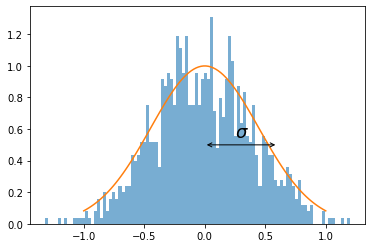

In [161]:
_ = pl.hist(X, bins=100, density=True, alpha=0.6)
x = np.linspace(-1,1, 100)
y = np.exp(-x**2/std)
pl.plot(x,y)
pl.annotate(text='',  xy=(0,0.5), xytext=(0.6,0.5), arrowprops=dict(arrowstyle='<->'))
_ = pl.text(0.25, .55, '$\sigma$', fontsize=18)


In [256]:
x_mean = np.array([0,0])
x_cov = np.array([[1,0.9],
                    [0.9,1]])

In [257]:
X = mln(x_mean, x_cov, size=1000)

In [164]:
X.shape

(1000, 2)

In [249]:
def normal_contour(x1,x2, x_cov):
    """ Multivariate Normal function for given X and covariance matrix"""
    x = np.array([x1,x2], dtype=float)
    return np.exp(-(x1*x_cov[0,0]*x1 + x1*x_cov[0,1]*x2 + x2*x_cov[1,0]*x1 + x2*x_cov[1,1]*x2))

### Visualize a bivariate normal distribution

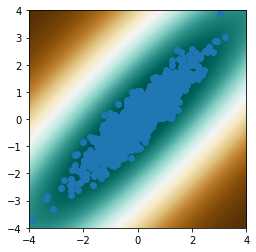

In [265]:
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)
xx1, xx2 = np.meshgrid(x1, x2)
x_cov = np.array([[1,.9],
                 [0.9,1]])
z = normal_contour(xx1, xx2, x_cov)
pl.imshow(z,  cmap=pl.cm.BrBG, extent=[-4,4,-4,4])
pl.scatter(X[:,0], X[:,1])

### Principal Component Analysis

With `PCA` one can find the directions in the feature space that the variation is largest. However in this basic approach the variation of variables respect to the target is disregarded. 

In [144]:
from sklearn.decomposition import PCA

In [145]:
pca = PCA()

In [148]:
pca.fit(X)

PCA()

In [149]:
x_transformed = pca.transform(X)

In [150]:
x_transformed.shape, X.shape

((1000, 2), (1000, 2))

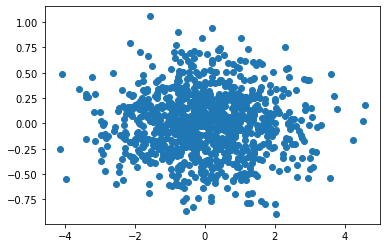

In [151]:
pl.scatter(x_transformed[:,0], x_transformed[:,1])

In [153]:
pca.explained_variance_

array([1.81821701, 0.09678571])

## Clustering and regression on clusters
The approach that we take in this section is to build a robust regression by mean of clustering. The process is start by applying a multi-cluster (number of cluster is quite large that we are sure that we passed the elbow criteria). Two different outcomes are expected:
1. There are few clusters that contain the majority of data.
2. Dataset is distributed among clusters almost uniformly.

If outcome 1 happens, the regression model of interest will be trained on the sorted clusters based on their population from large to small. The test error will be measured every time a new cluster is added to the training dataset. The accumulated clusters with minimum generalization error will be used as the final trained model.

If the scenario 2 happens, then there would be no preferance among the clusters. The best course of action would be similar to *cross validation* by taking one cluster of data out and train on the rests. The best model can be picked either by taking average (need to be spicific, if it is a decision tree based model the average of models does not mean anything), or exclude one cluster that when it is added to the training dataset increase the generalization error dramaticly.

### Form of outliers and distibution of data points


### Steps:
- [ ] Generate some dataset.
- [ ] Add a uniform noise to original data.
- [ ] Build a simple regression model
- [ ] Apply idea of multiple cluster clustering.
- [ ] Train the same model on clusters accumulatively.

### Two Scenario
Here we identify two specific forms of outliers:
1. Outliers are uniformly distributated in range of inliers
2. Outliers are isolated in the feature space

Discuss the *isolation* of outliers and *curse of dimensionality*

## Generating data with outliers
In this example outliers are completely isolated from the inliers.

In [3]:
from sklearn.datasets import make_blobs, make_moons

In [4]:
rnd.seed(47)

In [74]:
# parameters 
size_data = 500
ratio_outliers = 0.1
size_outliers = int(ratio_outliers*size_data)
size_inliers = size_data - size_outliers

# Generate one cluster of data for inliers
X_in, _ = make_blobs(n_samples=size_inliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: linear function of features
y_in = a1*X_in[:,0] + a2*X_in[:,1] + rnd.rand(size_inliers)


In [75]:
# outliers
X_out, _ = make_blobs(n_samples=size_outliers, n_features=2, centers=1)
a1 = 1.2
a2 = 2.1
# target: just a random noise in the same range of inlier data
y_out = (y_in.max() - y_in.min()) * rnd.rand(size_outliers) 

### Concatonate `inliers` and `outliers`

In [76]:
X = np.r_[X_in, X_out]
y = np.r_[y_in, y_out]

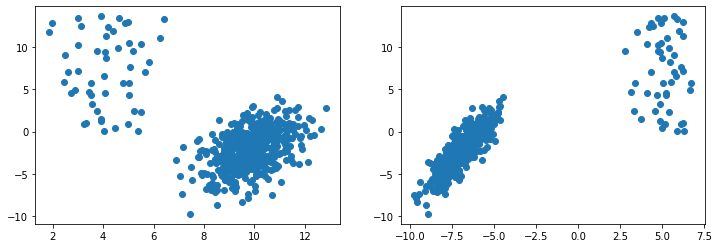

In [77]:
fig, ax = pl.subplots(1,2, figsize=(12,4))
ax[0].scatter(X[:,0], y)
ax[1].scatter(X[:,1], y)


In [78]:
import seaborn as sns

In [79]:
X.shape, y.shape

((500, 2), (500,))

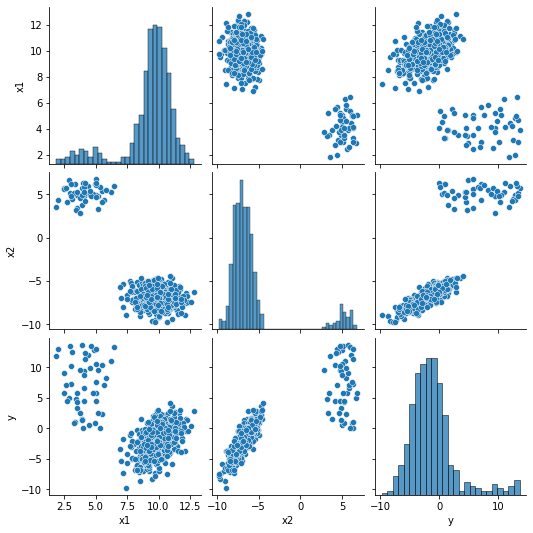

In [80]:
data = pd.DataFrame(np.c_[X,y], columns=['x1', 'x2','y'])
sns.pairplot(data)

## Training a model

### Without outlier treatment

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [83]:
lr = LinearRegression()

In [84]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [85]:
train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [86]:
print("train MAE: {:.3} and test MAE: {:.3}".format(train_mae, test_mae))

train MAE: 0.9 and test MAE: 0.988


## With outlier treatmet
- What is the best performance that one get if we remove outliers completely?

In [87]:
# make a train-test on inliers
X_train, X_test, y_train, y_test = train_test_split(X_in, y_in, test_size=0.33, random_state=42)

In [88]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)


In [89]:
train_mae, test_mae

(0.24718639234284087, 0.2501887305712267)

### Clustering with large number of clusters
- [ ] Apply clustering, make sure you pass elbow criteria.
- [ ] Sort cluster based on their population.
- [ ] Start training from high population accumulatively.
- [ ] Measure generalization error.
- [ ] Plot error agains clusters.

In [90]:
from sklearn.cluster import KMeans

In [91]:
km = KMeans(n_clusters = 10)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [93]:
km.fit(X_train)

KMeans(n_clusters=10)

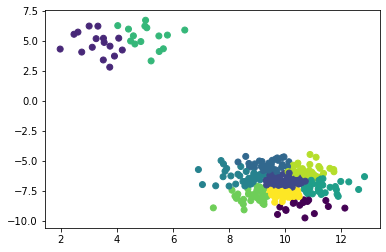

In [95]:
pl.scatter(X_train[:,0], X_train[:,1], c = km.labels_)

#### Population of clusters

In [96]:
cluster_populations = {i:km.labels_[km.labels_ == i].size for i in range(0,10)}

In [97]:
# sort cluster based on their population
cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), key=lambda el: el[1], reverse=True)]

In [98]:
cluster_sorted_key

[2, 9, 5, 7, 4, 8, 3, 0, 1, 6]

In [143]:
X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
for cl in cluster_sorted_key[1:]:
    lr.fit(X_cum, y_cum)
    print("Score: {:.3}".format(lr.score(X_test, y_test)))
    X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
    y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]

Score: 0.187
Score: 0.775
Score: 0.76
Score: 0.745
Score: 0.788
Score: 0.797
Score: 0.796
Score: 0.796
Score: 0.796


The way that we measure the performance is not fair.  Either remove outliers and them train/test split or do not compare the result against purely from `inliers`.


In [124]:
def cluster_regression(X, y):
    """ Performs clustering on dataset. Learn a regression model over clusters accumulatively.
    
    input:
    ------
    X: np.array, design matrix
    y: np.array, target vector (labels)
    
    output:
    -------
    model: sklearn trained model, best model
    """
    # TODO: 
    # - right way to decide the number of clusters
    # - devide to validation, test, cross validation 
    # ...
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=42)

    # Clustering
    n_clusters = 10
    km = KMeans(n_clusters = n_clusters)
    km.fit(X_train)
    # calculate population of clusters
    cluster_populations = {i:km.labels_[km.labels_ == i].size 
                           for i in range(0,n_clusters)}
    
    # sort cluster based on their population
    cluster_sorted_key = [c[0] for c in sorted(cluster_populations.items(), 
                                               key=lambda el: el[1], 
                                               reverse=True)]
    # Regression
    X_cum = X_train[km.labels_ == cluster_sorted_key[0]]
    y_cum = y_train[km.labels_ == cluster_sorted_key[0]]
    for cl in cluster_sorted_key[1:]:
        lr.fit(X_cum, y_cum)
        print("Score: {:.3}".format(lr.score(X_test, y_test)))
        X_cum = np.r_[X_cum, X_train[km.labels_ == cluster_sorted_key[cl]]]
        y_cum = np.r_[y_cum, y_train[km.labels_ == cluster_sorted_key[cl]]]

In [133]:
cluster_regression(X,y)

Score: 0.105
Score: 0.27
Score: 0.27
Score: 0.265
Score: 0.322
Score: 0.323
Score: 0.789
Score: 0.799
Score: 0.799
